In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

1.13.0+cu116
0.13.0+cu116


In [2]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 5.1 MB/s 
     |████████████████████████████████| 79 kB 8.0 MB/s 
     |████████████████████████████████| 10.2 MB 38.9 MB/s 
     |████████████████████████████████| 140 kB 60.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.


In [3]:
import io
import os
import tarfile
import tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


  0%|          | 0.00/7.99k [00:00<?, ?B/s]

  0%|          | 0.00/106k [00:00<?, ?B/s]

  0%|          | 0.00/53.2k [00:00<?, ?B/s]

## Querying audio metadata
Function `torchaudio.info()` fetches audio metadata. You can provide a **path-like** object or **file-like** object.



In [4]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


Where

- sample_rate is the sampling rate of the audio

- num_channels is the number of channels

- num_frames is the number of frames per channel

- bits_per_sample is bit depth

- encoding is the sample coding format

encoding can take on one of the following values:

- "PCM_S": Signed integer linear PCM

- "PCM_U": Unsigned integer linear PCM

- "PCM_F": Floating point linear PCM

- "FLAC": Flac, Free Lossless Audio Codec

- "MP3" : MP3, MPEG-1 Audio Layer III

- "GSM": GSM-FR

### Note

- bits_per_sample can be 0 for formats with compression and/or variable bit rate (such as MP3).

- num_frames can be 0 for GSM-FR format.

## Querying file-like object

In [5]:
url = "https://download.pytorch.org/torchaudio/tutorial-assets/steam-train-whistle-daniel_simon.wav"
with requests.get(url, stream=True) as response:
  metadata = torchaudio.info(response.raw)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


### Note:
When passing a file-like object, info does not read all of the underlying data; rather, it reads only a portion of the data from the beginning. Therefore, for a given audio format, it may not be able to retrieve the correct metadata, including the format itself. In such case, you can pass format argument to specify the format of the audio.

##Loading audio data To load audio data, you can use torchaudio.load().

- This function accepts a path-like object or file-like object as input.

- The returned value is a tuple of waveform (Tensor) and sample rate (int).

- By default, the resulting tensor object has dtype=torch.float32 and its value range is [-1.0, 1.0].

In [6]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [7]:
def plot_waveform(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  print(num_channels)
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
  figure.suptitle('WaveForm')
  plt.show(block=False)

1


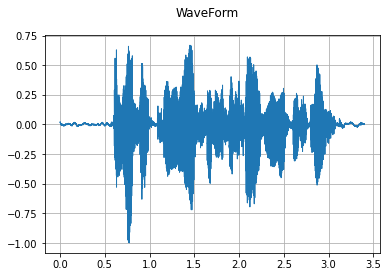

In [8]:
plot_waveform(waveform, sample_rate)

In [9]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

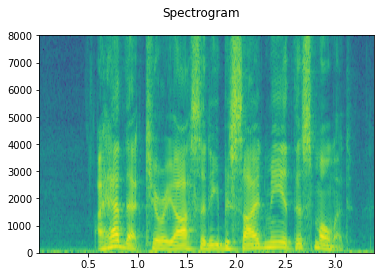

In [10]:
plot_specgram(waveform, sample_rate)

In [11]:
Audio(waveform.numpy()[0], rate=sample_rate)

## Looking from file-like object 
The I/O functions support **file-like** objects. This allows for fetching and decoding audio data from locations within and beyond the local file system. 

1


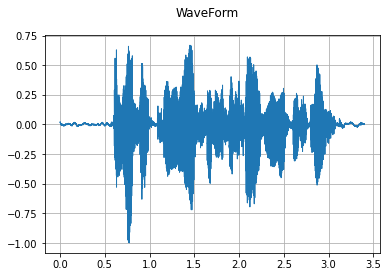

In [14]:
# Load audio data as HTTP request
url = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
with requests.get(url, stream=True) as response:
  waveform, sample_rate = torchaudio.load(response.raw)
plot_waveform(waveform, sample_rate)

  0%|          | 0.00/110k [00:00<?, ?B/s]

1


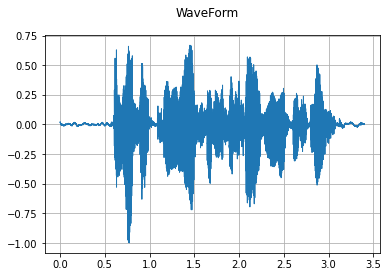

In [15]:
# Load audio from tar file
tar_path = download_asset("tutorial-assets/VOiCES_devkit.tar.gz")
tar_item = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

with tarfile.open(tar_path, mode='r') as tarfile_:
  fileobj = tarfile_.extractfile(tar_item)
  waveform, sample_rate = torchaudio.load(fileobj)

plot_waveform(waveform, sample_rate)

1


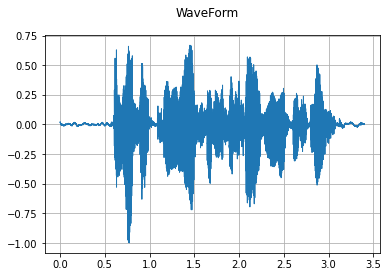

In [16]:
# Load audio from S3
bucket = "pytorch-tutorial-assets"
key = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=bucket, Key=key)
waveform, sample_rate = torchaudio.load(response["Body"])

plot_waveform(waveform, sample_rate)

## Tips on Slicing
Providing `num_frames` and `frame_offset` arguments restricts decoding to the corresponding segment of the input.

The same result can be achieved using vanilla Tensor slicing, (i.e. waveform`[:, frame_offset:frame_offset+num_frames]`). However, providing num_frames and frame_offset arguments is more efficient.

This is because the function will end data acquisition and decoding once it finishes decoding the requested frames. This is advantageous when the audio data are transferred via network as the data transfer will stop as soon as the necessary amount of data is fetched.

Fetching all the data...
 - Fetched 108844 bytes
1


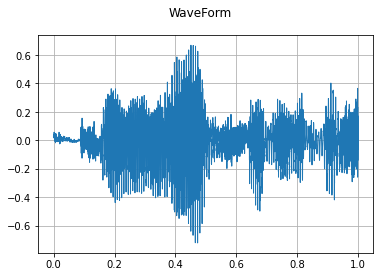

Fetching untill the requested frames are available...
- Fetched 65580 bytes
1


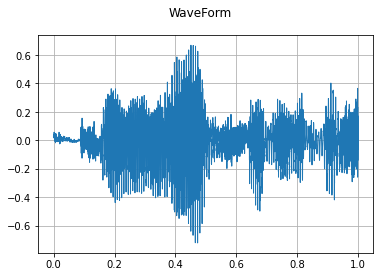

Checking the resulting waveform ... 
matched


In [20]:
# Illustration of two different decoding methods.
# The first one will fetch all the data and decode them, while
# the second one will stop fetching data once it completes decoding.
# The resulting waveforms are identical.

frame_offset, num_frames = 16000, 16000

url = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
print("Fetching all the data...")

with requests.get(url, stream=True) as response:
  waveform1, sample_rate1 = torchaudio.load(response.raw)
  waveform1 = waveform1[:, frame_offset : frame_offset + num_frames]
  print(f' - Fetched {response.raw.tell()} bytes')

plot_waveform(waveform1, sample_rate1)

print('Fetching untill the requested frames are available...')
with requests.get(url, stream=True) as response:
  waveform2, sample_rate2 = torchaudio.load(response.raw, frame_offset=frame_offset, num_frames=num_frames)
  print(f'- Fetched {response.raw.tell()} bytes')

plot_waveform(waveform2, sample_rate2)

print("Checking the resulting waveform ... ", end="")
assert(waveform1 == waveform2).all()
print('\nmatched')

## Saving audio to file
To save audio data in formats interpretable by common applications, you can use `torchaudio.save()`.

This function accepts a path-like object or file-like object.

When passing a file-like object, you also need to provide argument format so that the function knows which format it should use. In the case of a path-like object, the function will infer the format from the extension. If you are saving to a file without an extension, you need to provide argument format.

When saving WAV-formatted data, the default encoding for float32 Tensor is **32-bit floating-point PCM**. You can provide arguments `encoding` and `bits_per_sample` to change this behavior. For example, to save data in **16-bit** signed integer **PCM**, you can do the following.

Saving data in encodings with a lower bit depth reduces the resulting file size but also precision.

In [21]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()

Save without any encoding option. The function will pick up the encoding which the provided data fit



In [22]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_default.wav"
    torchaudio.save(path, waveform, sample_rate)
    inspect_file(path)

----------
Source: /tmp/tmpjnquxbwn/save_example_default.wav
----------
 - File size: 217658 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=32, encoding=PCM_F)



Save as 16-bit signed integer Linear PCM The resulting file occupies half the storage but loses precision



In [23]:
from random import sample
with tempfile.TemporaryDirectory() as tempdir:
  path = f"{tempdir}/save_example_PCM_S16.wav"
  torchaudio.save(path, waveform, sample_rate, encoding = "PCM_S", bits_per_sample=16)
  inspect_file(path)

----------
Source: /tmp/tmpc00bx8kv/save_example_PCM_S16.wav
----------
 - File size: 108844 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)



### Saving to file-like object
Similar to the other I/O functions, you can save audio to file-like objects. When saving to a file-like object, argument `format` is required.

In [25]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

#saving to bytes buffer
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format='wav')

buffer_.seek(0)
print(buffer_.read(16))

b'RIFF2R\x03\x00WAVEfmt '
